<a href="https://www.kaggle.com/samuelnordmann/image-classification-on-intel-dataset?scriptVersionId=88385093" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Image classification on Intel dataset

In this notebook, I propose an original implementation from scratch of an image classifier on the Intel dataset (https://www.kaggle.com/puneet6060/intel-image-classification). This dataset is composed of about 17k images belonging to different 6 classes. 

The algorithm achieves more than 90% accuracy on the test set (see the last output of the notebook for exact accuracy).

First, we explore the data and create a data generator with data augmentation. Then we train and evaluate two different models:
- a CNN network with 3 convolutional layers
- a pre-trained Inceptionv3 model (https://www.kaggle.com/google-brain/inception-v3) followed by a dense NN with 3 layers

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import PIL
import IPython.display

print(tf.__version__)

2.6.2


# Data exploration

First, let us explore the dataset. We print the number of training and testing examples in each class

In [2]:
dir_path='../input/intel-image-classification/'

nsample = pd.DataFrame()
data_stats = pd.DataFrame()
paths=dict()


for dataset in ['train','test']:
    path = os.path.join(dir_path,'seg_'+dataset)
    path = os.path.join(path,'seg_'+dataset)
    paths[dataset]=path
    labels = os.listdir(path)
    

    
    nsample_class = pd.Series({label: len(os.listdir(os.path.join(path,label))) for label in labels},
                              name=dataset)
    data_stats = data_stats.append(nsample_class)


data_stats["Total"] = data_stats.sum(axis=1)

data_stats

,mountain,street,buildings,sea,forest,glacier,Total
train,2512.0,2382.0,2191.0,2274.0,2271.0,2404.0,14034.0
test,525.0,501.0,437.0,510.0,474.0,553.0,3000.0


Let us plot now the ratio of each category in the training set

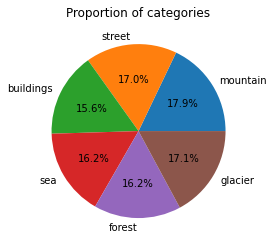

In [3]:
plt.pie(data_stats.loc["train"].values[:-1],
        labels=data_stats.columns[:-1],
        autopct='%1.1f%%')
plt.title('Proportion of categories')
plt.show()

Let us now take a random training sample and display it

Here is an example of an image of size (150, 150) of the class:  glacier


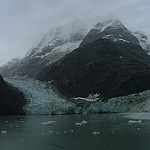

In [4]:
def random_training_sample():
    label = random.choice(labels)
    
    files_path = os.path.join(paths["train"],label)
    files = os.listdir(files_path)
    file = random.choice(files)
    file_path = os.path.join(files_path, file)
    return file_path, label


file_path, label = random_training_sample()

#read and display the image and its class
print("Here is an example of an image of size", PIL.Image.open(file_path).size,"of the class: ", label)
IPython.display.Image(file_path)




All the files have the following dimensions:

In [5]:
img_height = 150
img_width = 150

# Generation of augmented data

In [6]:
def create_datagenerators(batch_size, train_path=paths["train"], test_path=paths["test"]):
    train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                          rotation_range=10,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

    train_generator=train_datagen.flow_from_directory(
        paths["train"],
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')



    test_datagen = ImageDataGenerator(rescale = 1.0/255.)

    test_generator=test_datagen.flow_from_directory(
        paths["test"],
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    return train_generator, test_generator

batch_size = 32

train_generator, test_generator = create_datagenerators(batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Simple CNN model

Let us define a CNN model with 3 convolution layers followed by one dense layer and a softmax output. We also use Dropout and MaxPooling.

In [7]:
model = tf.keras.models.Sequential([
    # First convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # Second convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    #Third convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    #Flatten
    tf.keras.layers.Flatten(),
    #Dense Layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Dense+softmax final layer
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model. 
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-02-21 12:53:04.497875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 12:53:04.586458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 12:53:04.587542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 72, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       2

2022-02-21 12:53:04.589766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 12:53:04.590954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 12:53:04.591956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 12:53:04.593005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Let us now train the model on 10 epochs.

In [8]:
history = model.fit(train_generator, 
                              epochs=10, 
                              steps_per_epoch=int(data_stats.loc["train","Total"])//batch_size, 
                              validation_data = test_generator, 
                              verbose = 1, 
                              validation_steps=int(data_stats.loc["test","Total"])//batch_size)

2022-02-21 12:53:07.245615: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-21 12:53:08.789299: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


438/438 [==============================] - 139s 302ms/step - loss: 1.1345 - accuracy: 0.5578 - val_loss: 0.8699 - val_accuracy: 0.6848
Epoch 2/10
438/438 [==============================] - 89s 203ms/step - loss: 0.8655 - accuracy: 0.6743 - val_loss: 0.8505 - val_accuracy: 0.6835
Epoch 3/10
438/438 [==============================] - 89s 204ms/step - loss: 0.7295 - accuracy: 0.7290 - val_loss: 0.5851 - val_accuracy: 0.7836
Epoch 4/10
438/438 [==============================] - 90s 205ms/step - loss: 0.6631 - accuracy: 0.7591 - val_loss: 0.6204 - val_accuracy: 0.7658
Epoch 5/10
438/438 [==============================] - 90s 205ms/step - loss: 0.6206 - accuracy: 0.7757 - val_loss: 0.6030 - val_accuracy: 0.7786
Epoch 6/10
438/438 [==============================] - 90s 206ms/step - loss: 0.6008 - accuracy: 0.7797 - val_loss: 0.4400 - val_accuracy: 0.8505
Epoch 7/10
438/438 [==============================] - 90s 206ms/step - loss: 0.5557 - accuracy: 0.8009 - val_loss: 0.4383 - val_accuracy: 0.

We print the loss and accuracy and save the model:

2022-02-21 13:13:26.078317: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


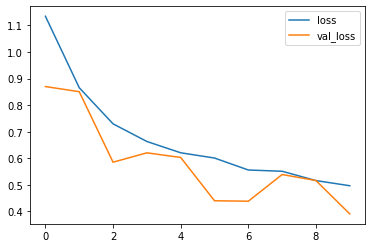

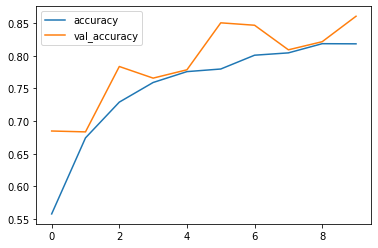

In [9]:
def print_save(model, history, name, save=True, plot=True):
    model.save(name)

    hist_df = pd.DataFrame(history.history)
    
    if save:
        hist_csv_file = name+'_history.csv'
        with open(hist_csv_file, mode='w') as f:
            hist_df.to_csv(f)
    if plot:
        hist_df[["loss",'val_loss']].plot()
        hist_df[["accuracy",'val_accuracy']].plot()
        
        
        
        
print_save(model, history, 'simple_model',save=False)


# Pre-trained Inception model

Let us now load a Inception model, which is pre-trained for the ImageNet Large Visual Recognition Challenge. We make the model non-trainable.

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an InceptionV3 model instance
pre_trained_model = InceptionV3(
    include_top=False, 
    weights=None,
    input_shape=(img_height,img_width,3), 
)


# Load the pre-trained weights
weights_file = "../input/inception-v3-weights-tf-dim-ordering-tf-kernelsh5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model.load_weights(weights_file)


# Make the pre-train model non trainable
for layer in pre_trained_model.layers:
  layer.trainable=False

In [11]:
#pre_trained_model.summary()

Let us connect the output of "mixed7" layer (outputshape=(batch_size, 7, 7, 768)) to a simple dense NN with 3 hidden layers.

In [12]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output
x = tf.keras.layers.Conv2D(512, (3,3), activation='relu')(last_output)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense(32,activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x) 
x = tf.keras.layers.Dense  (6,activation="softmax")(x)           
print(x.shape)
inception_model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x) 

inception_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


(None, 6)


In [13]:
#Definition of an early stopping callback
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10)


In [14]:
inception_history = inception_model.fit(train_generator, 
                              epochs=200, 
                              steps_per_epoch=int(data_stats.loc["train","Total"])//batch_size, 
                              validation_data = test_generator, 
                              verbose = 1, 
                              validation_steps=int(data_stats.loc["test","Total"])//batch_size,
                              callbacks=[EarlyStop])

Epoch 1/200
438/438 [==============================] - 95s 209ms/step - loss: 1.0221 - accuracy: 0.5844 - val_loss: 0.3463 - val_accuracy: 0.8804
Epoch 2/200
438/438 [==============================] - 92s 210ms/step - loss: 0.5362 - accuracy: 0.8180 - val_loss: 0.2941 - val_accuracy: 0.8955
Epoch 3/200
438/438 [==============================] - 92s 211ms/step - loss: 0.4528 - accuracy: 0.8521 - val_loss: 0.2619 - val_accuracy: 0.9079
Epoch 4/200
438/438 [==============================] - 92s 211ms/step - loss: 0.4033 - accuracy: 0.8673 - val_loss: 0.2683 - val_accuracy: 0.9066
Epoch 5/200
438/438 [==============================] - 93s 212ms/step - loss: 0.3758 - accuracy: 0.8811 - val_loss: 0.2578 - val_accuracy: 0.9163
Epoch 6/200
438/438 [==============================] - 96s 220ms/step - loss: 0.3626 - accuracy: 0.8837 - val_loss: 0.2627 - val_accuracy: 0.9116
Epoch 7/200
438/438 [==============================] - 95s 216ms/step - loss: 0.3461 - accuracy: 0.8905 - val_loss: 0.2587 -

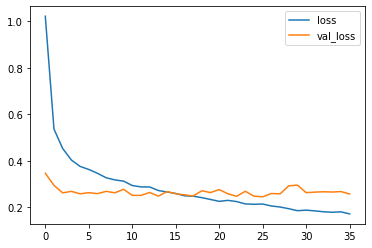

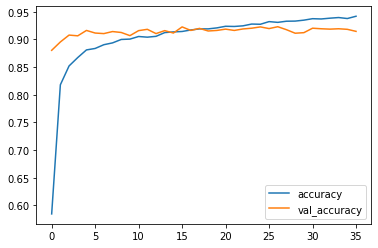

In [15]:
print_save(inception_model, inception_history, 'inception_model')